In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm
import torch

ROOT_DIR = "/home/cayetana/Storage/code/cayetana-best/heart-segmentation"
DATASET_PATH = "data/datasets/CT_HD_Whole_Heart_Segmentation/train"
os.chdir(ROOT_DIR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

label_map = {
    "background": {"color": "black", "value": 0.0},
    "left ventricle": {"color": "yellow", "value": 500.0, "description": "the left ventricle blood cavity"},
    "right ventricle": {"color": "skyblue", "value": 600.0, "description": "the right ventricle blood cavity"},
    "left atrium": {"color": "red", "value": 420.0, "description": "the left atrium blood cavity"},
    "right atrium": {"color": "purple", "value": 550.0, "description": "the right atrium blood cavity"},
    "myocardium": {"color": "blue", "value": 205.0, "description": "the myocardium of the left ventricle"},
    "ascending aorta": {"color": "orange", "value": 820.0, "description": "the ascending aorta"},
    "pulmonary artery": {"color": "green", "value": 850.0, "description": "the pulmonary artery"},
}
label_values = [meta["value"] for meta in label_map.values()]

## Dataset & Preprocessing

In [2]:
class MMWHSDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_dir, transform=None, target_transform=None, prefix="", postfix=""):

        self.inputs_paths = []
        self.targets_paths = []

        for path in sorted(os.listdir(image_dir)):
            if path.startswith(prefix) and path.endswith(f"_image.nii{postfix}"):
                self.inputs_paths.append(os.path.join(image_dir, path))
                
        for path in sorted(os.listdir(label_dir)):
            if path.startswith(prefix) and path.endswith(f"_label.nii{postfix}"):
                self.targets_paths.append(os.path.join(label_dir, path))

        if len(self.inputs_paths) != len(self.targets_paths):
            raise ValueError(f"Inputs and targets have different lengths: {len(self.inputs_paths)} vs {len(self.targets_paths)}")
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.inputs_paths)
    
    def __getitem__(self, idx):
        image_path = self.inputs_paths[idx]
        label_path = self.targets_paths[idx]

        image : np.ndarray = np.load(image_path)
        label : np.ndarray = np.load(label_path)

        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [ ]:
from torchvision import transforms

class ImagePreprocessing(object):
    def __call__(self, image : torch.Tensor):
        image = torch.unsqueeze(image, dim=0)
        return image

class LabelPreprocessing(object):
    def __init__(self, label_values):
        self.label_values = label_values

    def __call__(self, label : torch.Tensor):
        processed_label = torch.zeros(size=(len(self.label_values), *label.shape), dtype=torch.int32)
        for i, value in enumerate(self.label_values):
            processed_label[i] = torch.where(label == value, 1.0, 0.0)
        return processed_label

print(f"label_values: {label_values}")
train_dataset = MMWHSDataset(
    DATASET_PATH,
    DATASET_PATH,
    transform=transforms.Compose([
        ImagePreprocessing(),
    ]),
    target_transform=transforms.Compose(transforms=[
        LabelPreprocessing(label_values),
    ]),
    postfix=".npy.256256128.npy"
)

len(train_dataset)

label_values: [0.0, 500.0, 600.0, 420.0, 550.0, 205.0, 820.0, 850.0]


20

In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1)

## Dataset Statistics

In [5]:
def get_dataset_statistic(dataloader : DataLoader) -> tuple[float, float]:
    total_sum = 0.0
    total_squared_sum = 0.0
    total_pixels = 0
    
    for batch in dataloader:
        image, _ = batch
        image : torch.Tensor
        total_sum += image.sum()
        total_squared_sum += (image ** 2).sum()
        total_pixels += image.numel()
    mean = total_sum / total_pixels
    std = torch.sqrt((total_squared_sum / total_pixels) - (mean ** 2))
    
    return mean, std

mean, std = get_dataset_statistic(train_loader)
print(f"mean = {mean:.2f}, std = {std:.2f}")

mean = -798.60, std = 1132.57


## Model Inference

In [6]:
import heart_seg_app.models.unet3d as unet3d

hparams = {
        'n_channels':1,
        'n_classes':8,
    }
model = unet3d.Unet3D(None, train_loader, hparams)
CHECKPOINT_PATH = 'checkpoints/mmwhs_v1.ckpt'
checkpoint_file = torch.load(CHECKPOINT_PATH, weights_only=False)
model.load_state_dict(checkpoint_file['state_dict'])
# model.load_state_dict(torch.load('checkpoints/mmwhs_v1.pth', weights_only=False))
model = model.to(device)

{'n_channels': 1, 'n_classes': 8}


In [7]:
class Dice():
    def __init__ (self, smooth=1e-6):
        self.smooth = smooth
        self.by_classes = torch.tensor([])
        
    def __call__(self, outputs : torch.Tensor, targets : torch.Tensor):
        self.intersection = (outputs & targets).sum((2, 3, 4))
        self.union = (outputs | targets).sum((2, 3, 4))
        self.by_classes = (2 * self.intersection) / (self.union + self.intersection + self.smooth)
        return self.by_classes.mean(dim=0)
    
    def mean(self):
        return self.by_classes.mean(dim=1).mean(dim=0)

In [8]:
from tabulate import tabulate
import pandas as pd

dice = Dice()
label_names = label_map.keys()
table = pd.DataFrame({"idx": [], **{label_name: float for label_name in label_names}, "mean": []})

def mmwhs_label_postprocessing(label: torch.Tensor, label_values, order, device):
    label = label[:, order, ...]
    label = torch.softmax(label, dim=1).argmax(dim=1)
    batch_size, *spatial_size = label.size()
    processed_label = torch.zeros(size=(batch_size, len(label_values), *spatial_size), dtype=torch.int32, device=device)
    for i, value in enumerate(label_values):
        processed_label[:, i] = torch.where(label == value, 1, 0)

    return processed_label

with torch.no_grad():
    model.eval()
    for (inputs, targets) in tqdm(train_loader):
        inputs : torch.Tensor; targets : torch.Tensor
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        order = [0, 3, 5, 2, 4, 1, 6, 7]
        processed_outputs = mmwhs_label_postprocessing(outputs, label_values=list(range(8)), order=order, device=device)
        dice_by_classes = dice(processed_outputs, targets)
        mean_dice = dice.mean()
        new_row = pd.DataFrame([["image_idx", *dice_by_classes, mean_dice]], columns=table.columns)
        table = pd.concat([table, new_row], ignore_index=True)
        
        
print(tabulate(table, headers=list(table.columns), tablefmt="fancy_grid", numalign="center"))

  0%|          | 0/20 [00:00<?, ?it/s]

╒════╤═══════════╤══════════════╤══════════════════╤═══════════════════╤═══════════════╤════════════════╤══════════════╤═══════════════════╤════════════════════╤══════════╕
│    │ idx       │  background  │  left ventricle  │  right ventricle  │  left atrium  │  right atrium  │  myocardium  │  ascending aorta  │  pulmonary artery  │   mean   │
╞════╪═══════════╪══════════════╪══════════════════╪═══════════════════╪═══════════════╪════════════════╪══════════════╪═══════════════════╪════════════════════╪══════════╡
│ 0  │ image_idx │   0.987082   │     0.706859     │     0.873811      │   0.891761    │    0.91292     │   0.827829   │      0.84714      │      0.914865      │ 0.870283 │
├────┼───────────┼──────────────┼──────────────────┼───────────────────┼───────────────┼────────────────┼──────────────┼───────────────────┼────────────────────┼──────────┤
│ 1  │ image_idx │   0.993049   │     0.671079     │     0.690723      │   0.647812    │    0.833609    │   0.792949   │     0.121919  

In [9]:
with torch.no_grad():
    model.eval()
    it = iter(train_loader)
    batch = next(it)
    image, label = batch[0].to(device), batch[1].to(device)
    output = model(image)
    order = [0, 3, 5, 2, 4, 1, 6, 7]
    processed_outputs = mmwhs_label_postprocessing(outputs, label_values=list(range(8)), order=order, device=device)
    
    image = image[0].squeeze().cpu()
    label = label.argmax(dim=1)[0].cpu()
    preds = processed_outputs.argmax(dim=1)[0].cpu()
    print(image.shape, label.shape, preds.shape)

torch.Size([256, 256, 128]) torch.Size([256, 256, 128]) torch.Size([256, 256, 128])


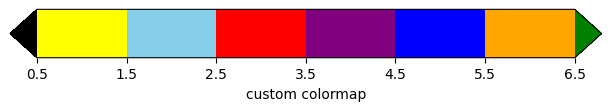

In [10]:
# make custom colormap
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt

color_dict = {
               "black": [0, "background"],
               "yellow": [1, "the myocardium of the left ventricle"],
               "skyblue": [2, "the left atrium blood cavity"],
               "red": [3, "the left ventricle blood cavity"],
               "purple": [4, "the right atrium blood cavity"],
               "blue": [5, "the right ventricle blood cavity"],
               "orange": [6, "the ascending aorta"],
               "green": [7, "the pulmonary artery"],
}
pixel_values = [value[0] for value in color_dict.values()]
colors = color_dict.keys()

mid_bounds = [(pixel_values[i] + pixel_values[i+1]) / 2 for i in range(len(pixel_values)-1)]
custom_cmap = matplotlib.colors.ListedColormap(list(colors)[1:], N=len(colors)).with_extremes(under='black', over='green')
norm = matplotlib.colors.BoundaryNorm(mid_bounds, custom_cmap.N - 2)

fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')
fig.colorbar(
    matplotlib.cm.ScalarMappable(cmap=custom_cmap, norm=norm),
    cax=ax, orientation='horizontal',
    extend='both',
    spacing='proportional',
    label='custom colormap',
)

torch.Size([256, 256, 128]) torch.Size([256, 256, 128])


/tmp/ipykernel_48318/805699152.py:10: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  ax[0].imshow(skimage.util.montage(image.T[0:100:25]), cmap="bone")


Text(0.5, 1.0, 'Prediction')

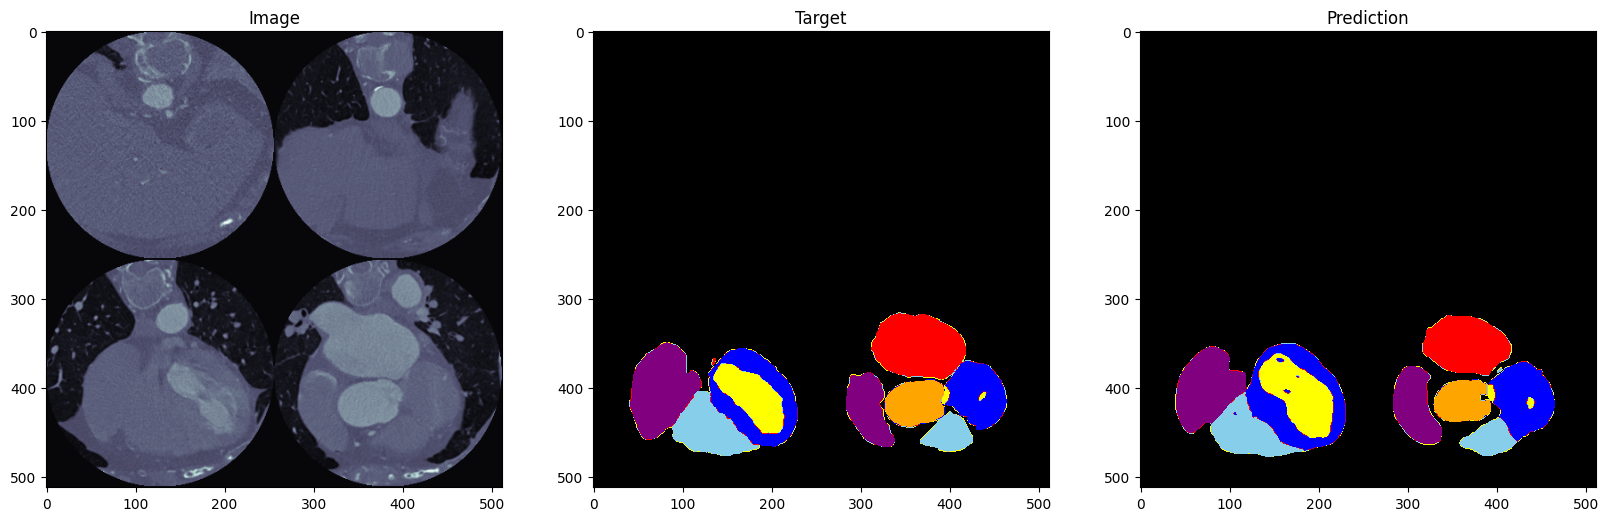

In [11]:
import skimage
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(20, 20))


print(image.shape, label.shape)


ax[0].imshow(skimage.util.montage(image.T[0:100:25]), cmap="bone")
ax[1].imshow(skimage.util.montage(label.T[0:100:25]), cmap=custom_cmap, norm=norm)
ax[2].imshow(skimage.util.montage(preds.T[0:100:25]), cmap=custom_cmap, norm=norm)
ax[0].set_title("Image")
ax[1].set_title("Target")
ax[2].set_title("Prediction")

In [12]:
import vtk

def vtk_visualize_3d_numpy_array(data : np.ndarray, cmap, pixel_values: list, apply_cfilter: bool = False):
    vtk_data = vtk.vtkImageData()
    vtk_data.SetDimensions(data.shape)
    vtk_data.SetSpacing([1, 1, 1])
    vtk_data.SetOrigin([0, 0, 0])
    vtk_data.AllocateScalars(vtk.VTK_INT, 1)

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                vtk_data.SetScalarComponentFromFloat(i, j, k, 0, data[i, j, k])

    image = vtk_data

    actors = []
    pixel_values = pixel_values[1:]
    renderer = vtk.vtkRenderer()
    for i in range(len(pixel_values)):

        marching_cubes = vtk.vtkDiscreteMarchingCubes()
        marching_cubes.SetInputData(image)
        marching_cubes.SetValue(0, pixel_values[i])
        marching_cubes.Update()
        mc_image = marching_cubes.GetOutputPort()

        if apply_cfilter:
            confilter = vtk.vtkPolyDataConnectivityFilter()
            confilter.SetInputConnection(mc_image)
            confilter.SetExtractionModeToLargestRegion()
            confilter.Update()
            mc_image = confilter.GetOutputPort()

        lookup_table = vtk.vtkLookupTable()
        lookup_table.SetNumberOfTableValues(1)
        lookup_table.Build()
        val = vtk.vtkNamedColors().GetColor3d(cmap.colors[i])
        lookup_table.SetTableValue(0, val[0], val[1], val[2], 1.0)

        mapper = vtk.vtkPolyDataMapper()
        mapper.AddInputConnection(mc_image)
        mapper.SetLookupTable(lookup_table)
        actor = vtk.vtkActor()
        actor.SetMapper(mapper)

        actors.append(actor)

        renderer.AddActor(actors[-1])

    window = vtk.vtkRenderWindow()
    window.AddRenderer(renderer)

    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(window)
    interactor.Initialize()
    renderer.Render()
    window.Render()
    interactor.Start()

vtk_visualize_3d_numpy_array(preds, cmap=custom_cmap, pixel_values=pixel_values)